In [1]:
import numpy as np
import matplotlib.pyplot as plt

- **Herfindal index**
$$
\mathcal{H}(N) \equiv \sum_{i=1}^N (\frac{x_i}{\sum_{j=1}^N  x_j})^2 \in (0,1]
$$

- **Dynamic**
$$
\frac{d}{dt}Z_i = m Z_i + \eta_i(t) Z_i \quad i = 1 \sim N
$$

where for all i( i.i.d), $\langle \eta_i(t) \rangle=0$, $\langle  \eta_i(t)  \eta_i(s)\rangle = \frac{\sigma^2}{2 \tau_c}e^{-\frac{\lvert t - s \rvert}{\tau_c}}$, $\langle \eta_i^2(t) \rangle = \frac{\sigma^2}{2\tau_c}$. 　

Here we choose $\eta_i(t)$ to be the Ornstein-Uhlenbeck process :
$$
\frac{d\eta(t)}{dt} = - \frac{1}{\tau_c} \eta(t) + \sigma dB_t
$$

For simulation, we let $\varepsilon_i(t) \sim N(0,\sigma^2 dt)$, $\eta_i(0) \sim N(0, \frac{\sigma^2}{1-(1-\frac{dt}{\tau_c})^2})$ and
compute
$$
\eta_i(t+dt) = \eta_i(t) - \frac{dt}{\tau_c} \eta_i(t) + \varepsilon_i(t)
$$

#### O-U process

In [119]:
1/(1-(1-dt/tau_c)**2), 1/(2*dt/tau_c)

(100.25062656641649, 100.0)

In [24]:
def OU(T,tau_c,sigma):
    dt = 0.01
    c = 1-dt/tau_c
    std = (sigma**2*dt/(1-c**2))**(1/2)
    eta_array=np.zeros(T+1)
    epsilon_array = np.random.normal(0,sigma*np.sqrt(dt),T)
    eta_array[0]=np.random.normal(0,std)
    for n in range(1,T+1):
        eta_array[n] = c*eta_array[n-1]+epsilon_array[n-1]
    return eta_array

In [25]:
dt = 0.01
tau_c=1.1
sigma=0.1
c = 1-dt/tau_c
std = (sigma**2*dt/(1-c**2))**(1/2)
eta_array =OU(100000,tau_c,sigma) #the convergence is very slow

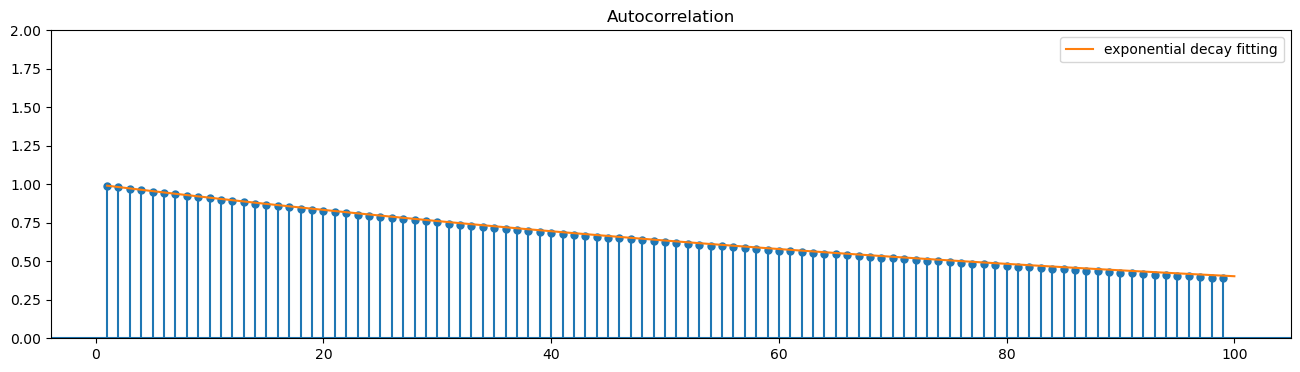

In [28]:
## ACF of OU process (lag can't be large since the convergence is slow)
from statsmodels.graphics.tsaplots import plot_acf
ACF=plot_acf(eta_array , lags=np.arange(1,100) ,alpha=None )
ACF.set_figwidth(16)
ACF.set_figheight(4)
    
T = np.linspace(1,100)
plt.plot(T,np.array([np.exp(-s*dt/tau_c) for s in T]) ,label="exponential decay fitting")
plt.ylim(0,2)
plt.legend()

#### Simulation

In [29]:
def Z_process(T,m,z_0,tau_c,sigma):
    dt = 0.01
    Z_array = np.ones(T+1)
    Z_array[0] = z_0
    eta_array = OU(T,tau_c,sigma)
    for i in range(1,T+1):
        ratio = 1+ (m+ (eta_array[i-1]+eta_array[i])/2 )*dt
        if ratio<0: #truncated when Z<0
            Z_array[i]=0
        else:
            Z_array[i] = ratio*Z_array[i-1]
    return Z_array

In [35]:
def Z_process_2(T,m,tau_c,sigma):
    xi = np.random.normal(0,1)
    return np.array([ np.exp( m*i*dt + sigma*np.sqrt(i*dt)*xi) for i in range(T+1)])

In [30]:
def H_index(Z_collection):
    H_array=np.zeros(len(Z_collection[0]))
    for s in range(len(Z_collection[0])):
        S = sum( Z_collection[:,s])
        if S==0:
            H_array[s]=0  #all die out => equally distributed
        else:
            H_array[s]= sum( (Z_collection[:,s]/ S)**2 )
    return H_array

Consider $m=2$, $\tau_c =2$, $Z_i(0)=1$ for all $i$, $dt=0.01$ and $\sigma=1$ for the simulation. 
When $t >> \tau_c$, it is said that the original process has the approximation by CLT:
$$
Z(t) = exp\big( mt + \int^t_0 \eta(s) ds \big) \sim exp\big( mt + \sqrt{\sigma^2 t} \xi\big) \qquad \text{where} \quad \xi \sim N(0,1)
$$

The typical value( or expected value) of the  Herfindahl index of the approximation process is said to have a phase transition at $t_c = \frac{2 \ln N}{\sigma^2}$ (this is not $\tau_c$) from equally distributed state to more concentrated state. Here we plot a realization of the Herfindahl index (for both original process and CLT approximation) in time in the below.

In [45]:
N= 2000
T= 40000
m=2
z_0=1
tau_c=2
dt=0.01
sigma=1

In [46]:
test=np.empty((N,T),dtype=object )
test_2=np.empty((N,T),dtype=object )
for i in range(N):
    if i % 100 ==0 :
        print(i)
    test[i,:] = Z_process(T-1,m,z_0,tau_c,sigma)
    test_2[i,:] = Z_process_2(T-1,m,tau_c,sigma)
H_array_1 = H_index(test)
H_array_2 = H_index(test_2)


0


C:\Users\std92\AppData\Local\Temp\ipykernel_19104\688097900.py:11: RuntimeWarning: overflow encountered in scalar multiply
  Z_array[i] = ratio*Z_array[i-1]
C:\Users\std92\AppData\Local\Temp\ipykernel_19104\923124046.py:3: RuntimeWarning: overflow encountered in exp
  return np.array([ np.exp( m*i*dt + sigma*np.sqrt(i*dt)*xi) for i in range(T+1)])


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


C:\Users\std92\AppData\Local\Temp\ipykernel_19104\1647331730.py:8: RuntimeWarning: invalid value encountered in divide
  H_array[s]= sum( (Z_collection[:,s]/ S)**2 )


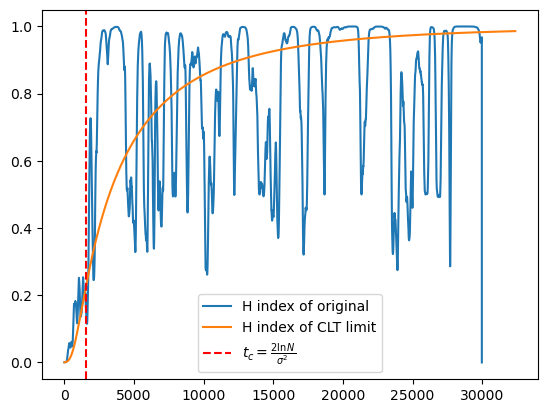

In [56]:
plt.plot( H_array_1 , label="H index of original")
plt.plot( H_array_2 , label="H index of CLT limit")
plt.axvline(2*np.log(N)/(sigma**2*dt) , color ='r' , ls='--',label=r'$t_c = \frac{2\ln N}{\sigma^2}$')
plt.legend()

- Original : grows quickly and then fluctuates dramatically 
- CLT : grows not so fast to 1( concentrated). Indeed, we sample N i.i.d standard normals, the maximal one will dominate in the sum in the H-index due to the exponential growth.

The phase transition is not so apparent. Maybe this is due to finite size effect( $N$ too small)?

In [182]:
def integral(T,tau_c,sigma):
    dt = 0.01
    N = int(np.floor(T/dt))
    c = 1-dt/tau_c
    std = (sigma**2*dt/(1-c**2))**(1/2)
    epsilon_array = np.random.normal(0,sigma*np.sqrt(dt),N)
    eta=np.random.normal(0,std)
    integral_value = 0
    for n in range(1,N+1):
        eta_new = c*eta+epsilon_array[n-1]
        integral_value += (eta)*dt
        eta = eta_new
    return integral_value

Given $T>0$, let $N= \lfloor \frac{T}{dt}\rfloor$ and we approximate the integral:

$$
\int^T_0 \eta(s) ds \sim \sum^N_{n=1} \eta(n\cdot dt) dt =dt\sqrt{N} \frac{\sum^N_{n=1} 
\eta(n\cdot dt)}{\sqrt{N}} \sim N(0,\frac{\sigma^2 \tau_c^2  }{2})
\sim N(0,\sigma^2 \tau_c^2 T)
$$

In [199]:
tau_c=1.31
dt=0.01
sigma=1.87
runs=10000
integral_array_3= np.zeros(runs)
for i in range(len(integral_array)):
    if i%1000==0:
        print(i)
    integral_array_3[i]=integral(1000,tau_c,sigma)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000


In [89]:
import scipy.stats

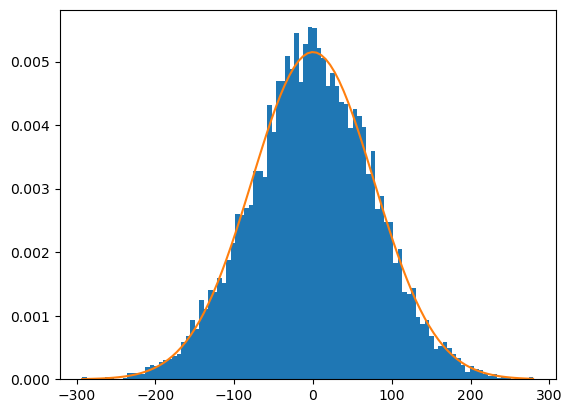

In [217]:
prob, bins, patches =plt.hist(integral_array_3,bins=100,density=True);
#plt.hist(integral_array_2,bins=100,density=True);
plt.plot(bins, scipy.stats.norm.pdf(bins,0, tau_c*sigma*np.sqrt(1000)))

31.622776601683793

In [215]:
tau_c*sigma*1000**0.5

77.4663158411448

In [180]:
integral(10000,tau_c,sigma)

(394.0700472316855,
 array([-0.63999525, -0.67920017, -0.58718154, ...,  0.35310871,
         0.42895777,  0.29718982]))